In [38]:
%load_ext autoreload
%autoreload 2

from tweedejaars_project import *
import os
import pandas as pd
import numpy as np
from sklearn.ensemble import *
from sklearn.tree import *
from sklearn.metrics import *
from sklearn.linear_model import *
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence
import matplotlib.pyplot as plt
from datetime import datetime

# TODO: DUbbelcheck of target echt overeenkomt met de sequence waarde
# TODO: Nan values
# TODO: False positives naar beneden halen
# TODO: Kijken of er nog iets anders is dan weighting


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
features = [
    "import_capacity",
    "mid_price_published",
    "upward_dispatch_published",
    "downward_dispatch_published",
    # 'min_ptu_price_known',
    # "max_ptu_price_known",
    "settlement_price_bestguess",
    'PTU',
    'forecast_wind',
    'forecast_solar',
    'forecast_demand',
    'time_since_last_two_sided',
    'two_sided_daily_count',
    'ptu_id',
    'naive_strategy_action',
    'minute_in_ptu'
]
# already used
target = 'fix_two_sided_ptu'

In [40]:
df = load_df()

In [41]:
def interpolate_feature(df, features):
    for feature in features:
        df[feature] = df[feature].ffill()  # TODO: kan misschien linear ipv fill maar idk hoe goed dat gaat werken met live data
    return df

# Fix rows for NaNs where it is allowed
df = interpolate_feature(df, ['forecast_wind', 'forecast_solar', 'forecast_demand', "upward_dispatch_published", "downward_dispatch_published"])


In [42]:
def difference_published(df, features):
    values = [0., 1., 2., 3.]
    conditions = [
        (df[features[0]].notna() & df[features[1]].isna()),  # feature1 has value, feature2 is NaN
        (df[features[0]].isna() & df[features[1]].notna()),  # feature1 is NaN, feature2 has value
        (df[features[0]].isna() & df[features[1]].isna()),   # both feature1 and feature2 are NaN
        (df[features[0]].notna() & df[features[1]].notna())  # both feature1 and feature2 have values
    ]
    df['publish_info'] = np.select(conditions, values)
    return df

# bool ipv 2 feature waardes
df = difference_published(df, ['min_price_published', 'max_price_published'])

In [43]:
def fill_vals_0(df, features):
    for feature in features:
        df[feature] = df[feature].fillna(0)
    
    return df

df = fill_vals_0(df, ['min_ptu_price_known', 'max_ptu_price_known', 'settlement_price_bestguess'])


In [44]:
# # df['upward_dispatch_published'].isna().any(axis=None)
# list(np.where(df['upward_dispatch_published'].isnull())[0])
# # upward_dispatch_published",

In [45]:
# Hyperparameters
# ptu_window = 10 # Dit is het PTU aantal dus ptu_id's niet row aantal
# batch_size = 7500
# hidden_size = 6
# num_layers = 2
# output_size = 1
# num_epochs = 1
# learning_rate = 0.001

input_size = len(features)  # Features
hidden_size = 10
num_layers = 1
output_size = 1
seq_length = 15  # 15 voor ptu_window dus 15 rows 
batch_size = seq_length * 3 
num_epochs = 1
learning_rate = 0.001



splits = get_splits(df, features)
# Split the data in vars
train_data = splits['train']
valid_data = splits['valid']
test_data = splits['test']

In [46]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state with zeros
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])  # out: tensor of shape (batch_size, output_size)
        return out

In [47]:
class TimeSeriesDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data_in = pd.DataFrame(data['in']).astype(np.float32)
        self.data_out = pd.Series(data['out']).astype(np.float32)
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data_in) - self.seq_length + 1

    def __getitem__(self, idx):
        sequence = self.data_in.iloc[idx:idx + self.seq_length].values
        target = self.data_out.iloc[idx + self.seq_length - 1]
        return torch.tensor(sequence, dtype=torch.float32), torch.tensor(target, dtype=torch.float32)

In [48]:
def prepare_data_loader(data, seq_length, batch_size):
    dataset = TimeSeriesDataset(data, seq_length)
    return DataLoader(dataset, batch_size=batch_size, shuffle=False)

# Assuming you have splits like train_data, valid_data, test_data
train_loader = prepare_data_loader(train_data, seq_length, batch_size)
valid_loader = prepare_data_loader(valid_data, seq_length, batch_size)
test_loader = prepare_data_loader(test_data, seq_length, batch_size)
print(len(test_loader))

1215


In [49]:
def train(model, train_loader, valid_loader, optimizer, criterion, num_epochs, device):

    train_losses = []
    valid_losses = []
    
    model.train()
    for epoch in range(num_epochs):
        train_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader):

            print(f"Training batch {i}, Sequence shape: {inputs.shape}, Lengths: {targets.shape}")
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Calculate validation loss after every epoch
        valid_loss = evaluate(model, valid_loader, criterion, device)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss / len(train_loader):.4f}, Valid Loss: {valid_loss:.4f}')
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)

    return train_losses, valid_losses


def evaluate(model, data_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            print(f"Validation batch {i}, Sequence shape: {inputs.shape}, Lengths: {targets.shape}")

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
    return total_loss / len(data_loader)

In [50]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)

tensor_target = torch.tensor(train_data['out']).float()
criterion = nn.BCEWithLogitsLoss(pos_weight=(len(tensor_target)/ tensor_target.sum()))
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, amsgrad=True)

train_losses, valid_losses = train(model, train_loader, valid_loader, optimizer, criterion, num_epochs, device)



Training batch 0, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 1, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 2, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 3, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 4, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 5, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 6, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 7, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 8, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 9, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 10, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Training batch 11, Sequence shape: torch.Size([45, 15

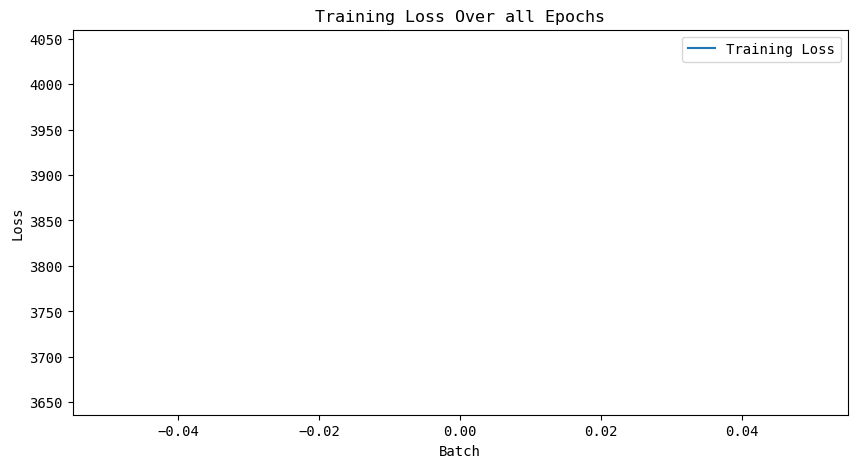

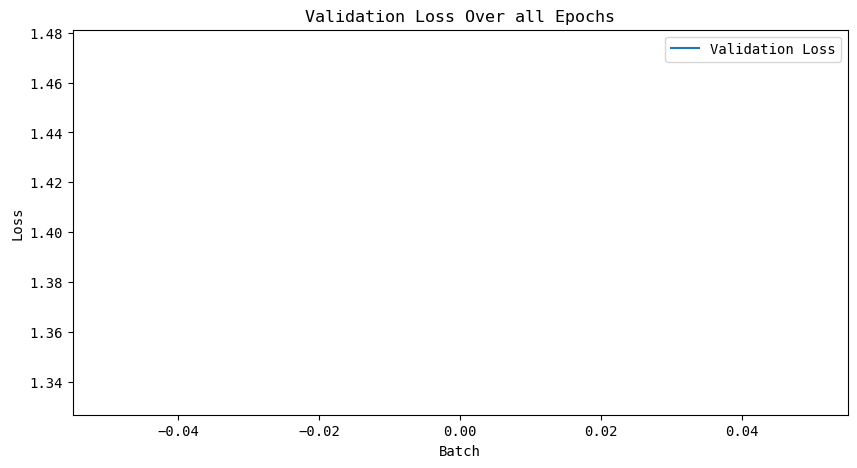

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over all Epochs')
plt.legend()
plt.show()


plt.figure(figsize=(10, 5))
plt.plot(valid_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Validation Loss Over all Epochs')
plt.legend()
plt.show()

In [52]:
save_model(model, 'scratch_rnn', 'rnn')

In [53]:
def test(model, test_loader, criterion, device):

    all_outputs = []

    model.eval()
    
    test_loss = 0.0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(test_loader):
            print(f"Test batch {i}, Sequence shape: {inputs.shape}, Lengths: {targets.shape}")

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            
            loss = criterion(outputs.squeeze(), targets)
            test_loss += loss.item()

            all_outputs.append(outputs)

    print(f'Test Loss: {test_loss / len(test_loader):.4f}')
    return torch.cat(all_outputs)

outputs = test(model, valid_loader, criterion, device)


Test batch 0, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 1, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 2, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 3, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 4, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 5, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 6, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 7, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 8, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 9, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 10, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 11, Sequence shape: torch.Size([45, 15, 14]), Lengths: torch.Size([45])
Test batch 12,

In [54]:
probabilities = torch.sigmoid(outputs)
predictions = (probabilities > 0.5)

print(torch.sum(predictions))

tensor(39007)


In [55]:
unaltered_df = valid_data['df'][:len(predictions)]
print(predictions)



tensor([[ True],
        [ True],
        [ True],
        ...,
        [False],
        [False],
        [False]])


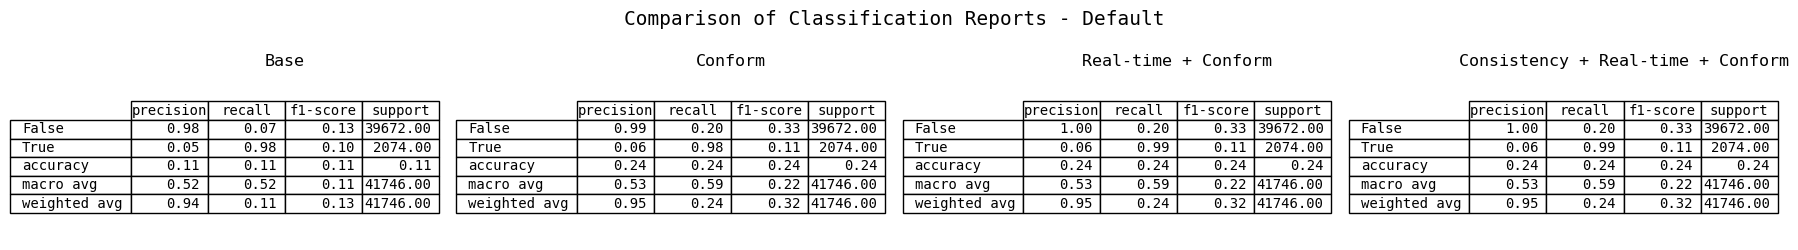

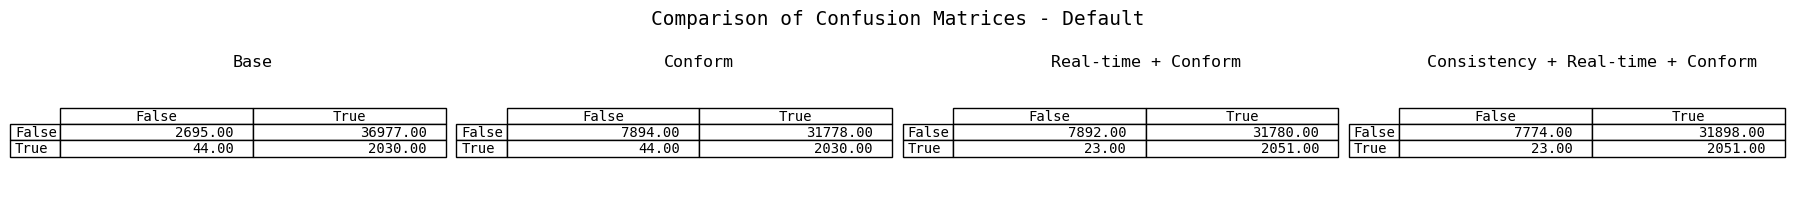

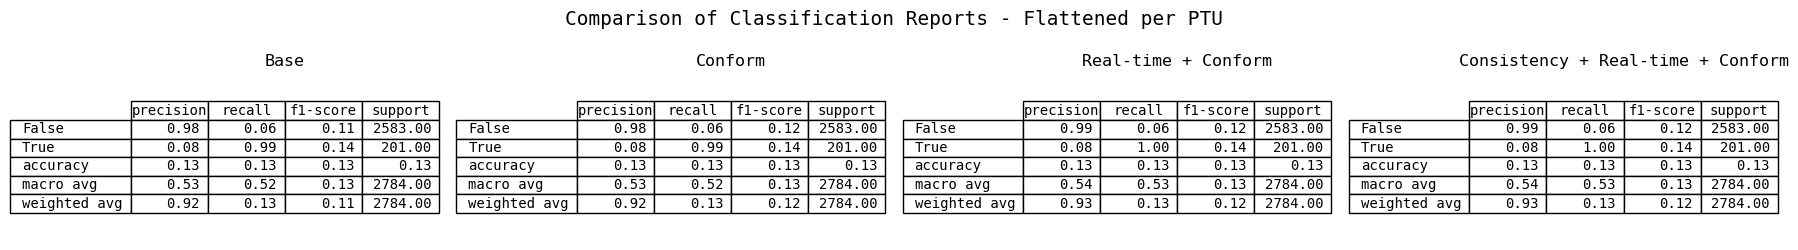

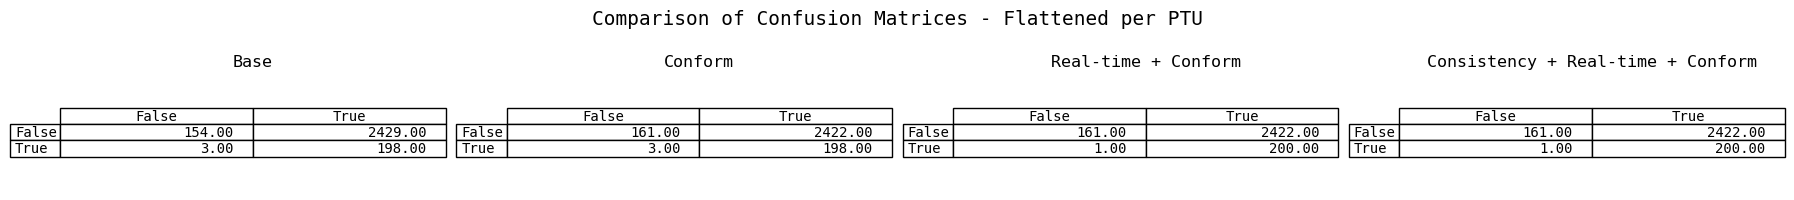

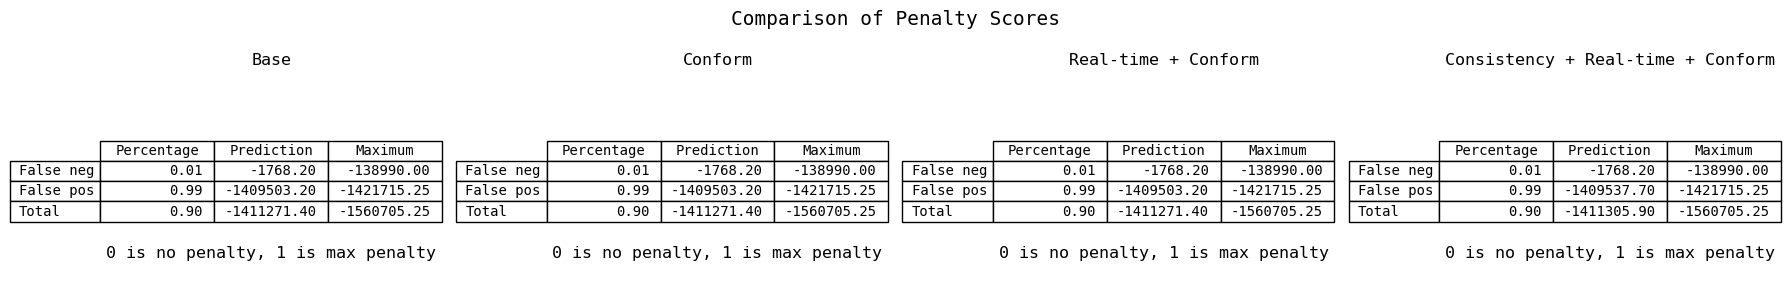

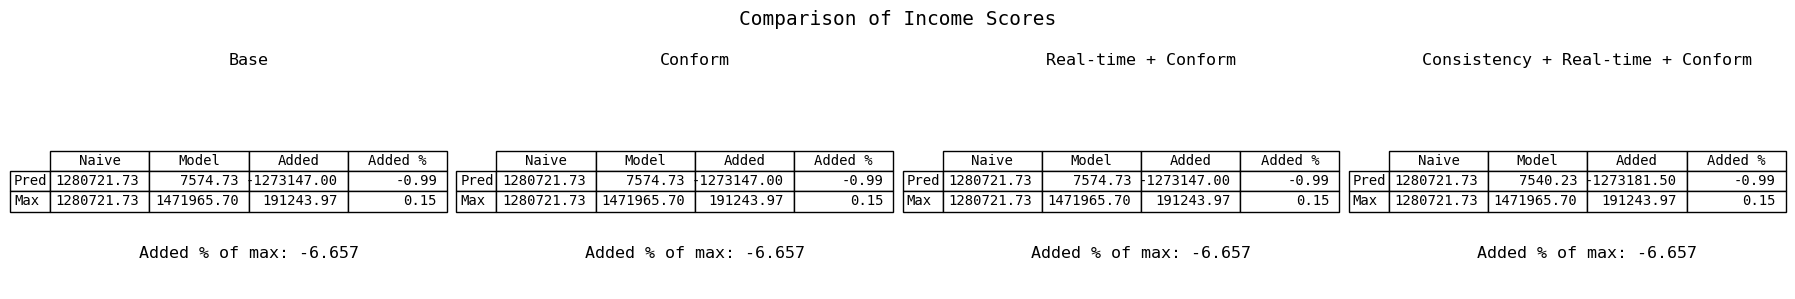

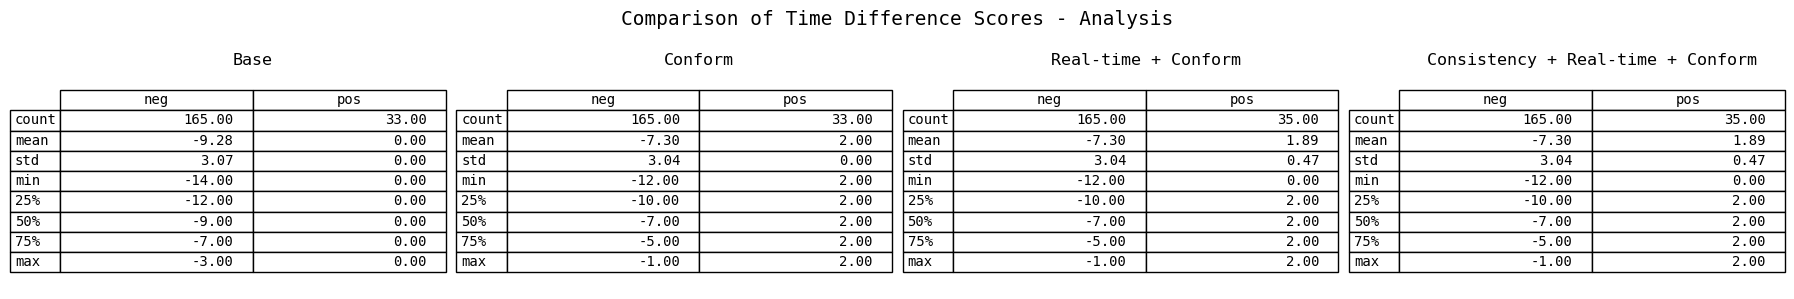

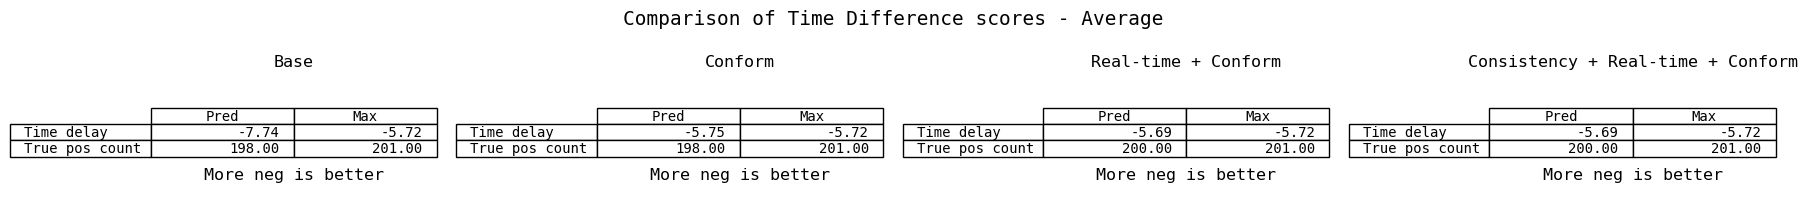

In [56]:
p1 = recast_pred(predictions.flatten()) # remake it into a series
show_metrics_adjusted(unaltered_df, p1)
